# Extracting Notes - symbol classification
This project consists in classifying different symbols present in a music sheet using different machine learning tehcniques.

Specifically, here the aim is to recognize between notes with beams 

In [1]:
import os
from muscima.io import parse_cropobject_list

# Change this to reflect wherever your MUSCIMA++ data lives
CROPOBJECT_DIR = os.path.join(os.environ['HOME'], 
                              'ML_course/Music_reading_project/MUSCIMA-pp_v0.9/v0.9/data/cropobjects')

cropobject_fnames = [os.path.join(CROPOBJECT_DIR, f) for f in os.listdir(CROPOBJECT_DIR)]
docs = [parse_cropobject_list(f) for f in cropobject_fnames]

In [2]:
def extract_notes_with_beam(cropobjects):
    "find all elements with beams"
    _cropobj_dict = {c.objid: c for c in cropobjects}
    notes_with_beam = []
    for c in cropobjects:
        if c.clsname == 'beam':
            c_list = []
            c_list.append(c)
            #we need to take the noteheads associated with the beam
            #plus all symbols associated with the respective noteheads
            for o in c.inlinks:
                o_obj = _cropobj_dict[o]
                c_list.append(o_obj)
                for p in o_obj.outlinks:
                    p_obj = _cropobj_dict[p]
                    if not p_obj in c_list:
                        if not p_obj.clsname=='slur':
                            c_list.append(p_obj)
            tup = tuple(c_list)
            notes_with_beam.append(tup)
    return notes_with_beam
                    
notes_beam = [extract_notes_with_beam(cropobjects) for cropobjects in docs]

In [3]:
import itertools 
notes = list(itertools.chain(*[note for note in notes_beam]))
print(len(notes))

6587


In [4]:
import numpy

def get_image(cropobjects, margin=1):
    """Paste the cropobjects' mask onto a shared canvas.
    There will be a given margin of background on the edges."""

    # Get the bounding box into which all the objects fit
    top = min([c.top for c in cropobjects])
    left = min([c.left for c in cropobjects])
    bottom = max([c.bottom for c in cropobjects])
    right = max([c.right for c in cropobjects])

    # Create the canvas onto which the masks will be pasted
    height = bottom - top + 2 * margin
    width = right - left + 2 * margin
    canvas = numpy.zeros((height, width), dtype='uint8')

    for c in cropobjects:
        # Get coordinates of upper left corner of the CropObject
        # relative to the canvas
        _pt = c.top - top + margin
        _pl = c.left - left + margin
        # We have to add the mask, so as not to overwrite
        # previous nonzeros when symbol bounding boxes overlap.
        canvas[_pt:_pt+c.height, _pl:_pl+c.width] += c.mask

    canvas[canvas > 0] = 1
    return canvas

In [5]:
note_images = [get_image(note) for note in notes]

In [6]:
import matplotlib.pyplot as plt

def show_mask(mask):
    plt.imshow(mask, cmap='gray', interpolation='nearest')
    plt.show()

def show_masks(masks, row_length=5):
    n_masks = len(masks)
    n_rows = n_masks // row_length + 1
    n_cols = min(n_masks, row_length)
    fig = plt.figure()
    for i, mask in enumerate(masks):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(mask, cmap='gray', interpolation='nearest')
    # Let's remove the axis labels, they clutter the image.
    for ax in fig.axes:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_xticks([])
    plt.show()

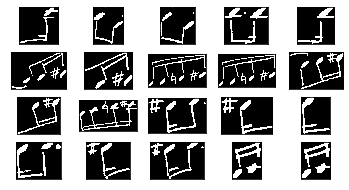

In [7]:
show_masks(note_images[35:55])

## Unsupervised learning

As most of the elements are either 4 16th notes and 2 8th notes we'll only take them and perform an unsupervised separation

In [8]:
def extract(cropobjects):
    "find all elements with beams"
    _cropobj_dict = {c.objid: c for c in cropobjects}
    eight_notes_pair = []
    sixteen_notes_quartet = []
    for c in cropobjects:
        if c.clsname == 'beam':
            #we need to take the noteheads associated with the beam
            #plus all symbols associated with the respective noteheads
            if len(c.inlinks)==2:
                c_list = []
                c_list.append(c)
                #extracting 8th notes
                for o in c.inlinks:
                    o_obj = _cropobj_dict[o]
                    c_list.append(o_obj)
                    for p in o_obj.outlinks:
                        p_obj = _cropobj_dict[p]
                        if p_obj.clsname=='stem':
                            c_list.append(p_obj)
                tup = tuple(c_list)
                eight_notes_pair.append(tup)
            elif len(c.inlinks)==4:
                c_list = []
                for o in c.inlinks:
                    o_obj = _cropobj_dict[o]
                    outlink_names=[_cropobj_dict[num].clsname for num in o_obj.outlinks]
                    if outlink_names.count('beam')==2:
                        c_list.append(o_obj)
                        for p in o_obj.outlinks:
                            p_obj = _cropobj_dict[p]
                            if p_obj.clsname=='stem' or p_obj.clsname=='beam':
                                c_list.append(p_obj)
                tup = tuple(c_list)
                if len(tup)>8:
                    sixteen_notes_quartet.append(tup)
    return eight_notes_pair, sixteen_notes_quartet
                    
notes_beam_ = [extract(cropobjects) for cropobjects in docs]

In [9]:
#number of 8th pairs
notes_8th = list(itertools.chain(*[note for note, other_note in notes_beam_]))
print(len(notes_8th))

2195


In [10]:
notes_16th = list(itertools.chain(*[other_note for note, other_note in notes_beam_]))
print(len(notes_16th))

733


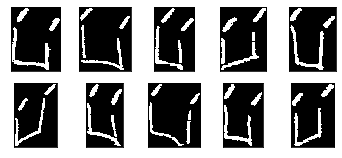

In [11]:
notes_8th_images = [get_image(note) for note in notes_8th]
show_masks(notes_8th_images[:10])

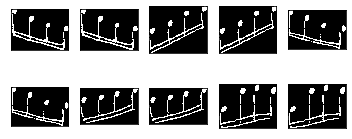

In [12]:
notes_16th_images = [get_image(note) for note in notes_16th]
show_masks(notes_16th_images[10:20])

In [14]:
from skimage.transform import resize
resized_8th = [resize(note, (200, 200)) for note in notes_8th_images]
for note in resized_8th:
    note[note > 0] = 1

In [15]:
resized_16th = [resize(note_, (200,200)) for note_ in notes_16th_images]
for note in resized_16th:
    note[note > 0] = 1

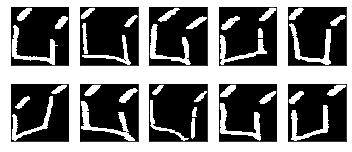

In [16]:
show_masks(resized_8th[:10])

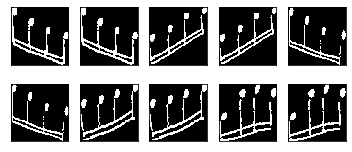

In [17]:
show_masks(resized_16th[10:20])

## Unsupervised clusetering
If all goes well, we will split 8th notes from 16th notes without labels...

In [18]:
from sklearn.model_selection import train_test_split

#labelling but only for testing
LABEL_8th = 0
LABEL_16th = 1

labels_8th = [LABEL_8th for _ in resized_8th]
labels_16th = [LABEL_16th for _ in resized_16th]
labels = labels_8th + labels_16th

notes = resized_8th + resized_16th

X_train, X_test, y_train, y_test = train_test_split(
    notes, labels, test_size=0.25, random_state=42,
    stratify=labels)

In [19]:
# Flatten data
notes_flattened_train = [n.flatten() for n in X_train]

In [20]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(notes_flattened_train)

### Cluster centres
We'll see if we got what we expected

In [21]:
centre_1 = kmeans.cluster_centers_[0]
centre_2 = kmeans.cluster_centers_[1]

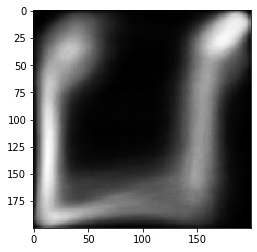

In [22]:
centre_1_matrix = centre_1.reshape((200, 200))
show_mask(centre_1_matrix)

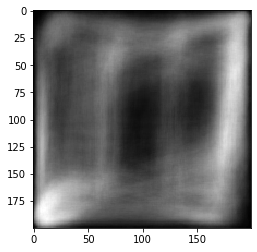

In [23]:
centre_2_matrix = centre_2.reshape((200, 200))
show_mask(centre_2_matrix)

We see that the first cluster centre is close to an inverted 4th note pair, however, the second cluster centre could eventually get confused with a non inverted 4th note pair. We'll try 3 clusters to address the inverted note set issue.

In [24]:
kmeans_3 = KMeans(n_clusters=3, random_state=0).fit(notes_flattened_train)

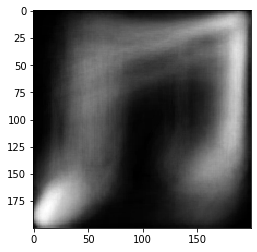

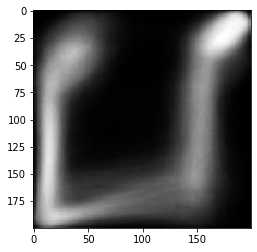

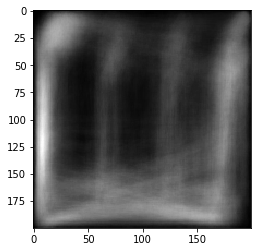

In [25]:
for centre in kmeans_3.cluster_centers_:
    centre_matrix = centre.reshape((200, 200))
    show_mask(centre_matrix)

In [26]:
notes_flattened_test = [n.flatten() for n in X_test]
prediction = kmeans_3.predict(notes_flattened_test)

In [27]:
actual_pred = []
for i in prediction:
    if i==0 or i==1:
        actual_pred.append(0)
    else:
        actual_pred.append(1)

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test, actual_pred, target_names=['8th_notes', '16th_notes']))

              precision    recall  f1-score   support

   8th_notes       0.92      0.72      0.81       549
  16th_notes       0.50      0.82      0.62       183

    accuracy                           0.75       732
   macro avg       0.71      0.77      0.71       732
weighted avg       0.82      0.75      0.76       732



### Interesting results: a weighted precission of 82% 
This could be further improved with filters, but at least we showed that an unsupervised approach is competitive with a supervised one!